In [2]:
# Imports
from fredapi import Fred
from dotenv import load_dotenv
import os
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px
import numpy as np
import seaborn as sns
import time
load_dotenv()
API_KEY = os.getenv('API_KEY')
fred = Fred(API_KEY)

# Explorative Analysis

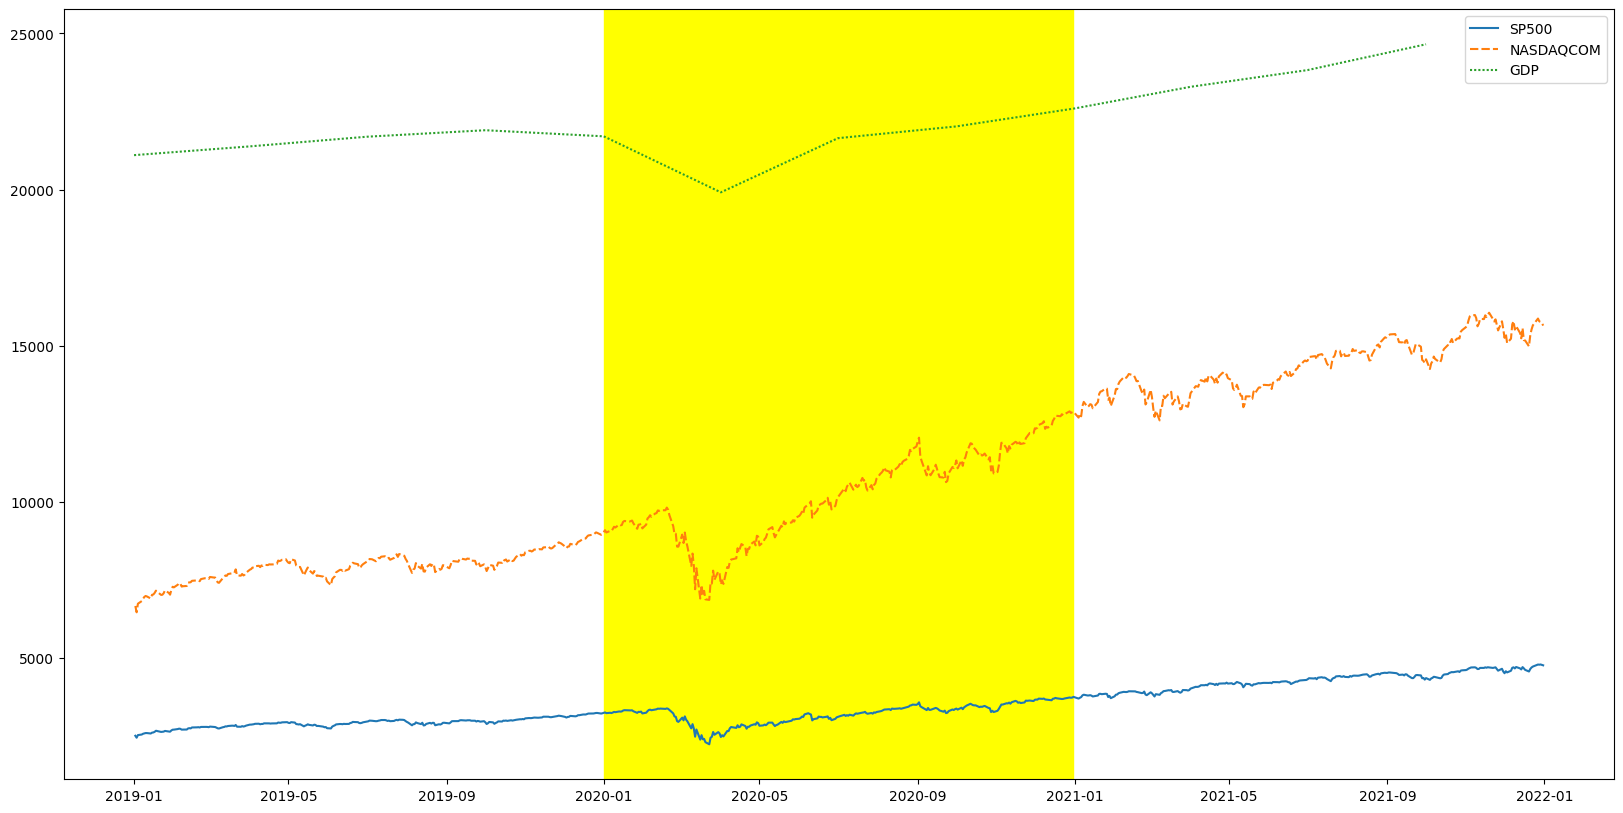

In [3]:
sp500 =  pd.Series(fred.get_series("SP500"), name="SP500")
nasdaqcom = pd.Series(fred.get_series("NASDAQCOM"), name="NASDAQCOM")
gdp = pd.Series(fred.get_series("GDP"), name="GDP")
inflation = pd.Series(fred.get_series("CPIAUCSL"), name='Inflation')
df = pd.DataFrame({sp500.name: sp500, nasdaqcom.name: nasdaqcom, gdp.name: gdp, inflation.name: inflation})

plt.figure(figsize=(20,10))
df2020 = df.iloc[:, 0:3]
df2020 = df2020[(df2020.index >="2019-01-01") & (df2020.index <= "2021-12-31")]
sns.lineplot(df2020)
plt.axvspan(pd.to_datetime("2020-01-01"), pd.to_datetime("2020-12-31"), color ='yellow', label="Covid Period")

In [4]:
# Getting the unemployment rate
unrate = fred.search("unemployment state")
unrate_filter = (unrate['seasonal_adjustment_short'] == "SA") & (unrate['frequency'] == 'Monthly') & (unrate['units'] == "Percent") & (unrate['title'].str.startswith("Unemployment Rate in"))
unrate = unrate[unrate_filter]

unrateSeries = []
for seriesId in unrate.index:
    unrateSeries.append(pd.Series(fred.get_series(seriesId), name=seriesId))
    time.sleep(0.2) # Senza veniva bloccata l' api
dfUnrate = pd.concat(unrateSeries, axis=1)


<Axes: >

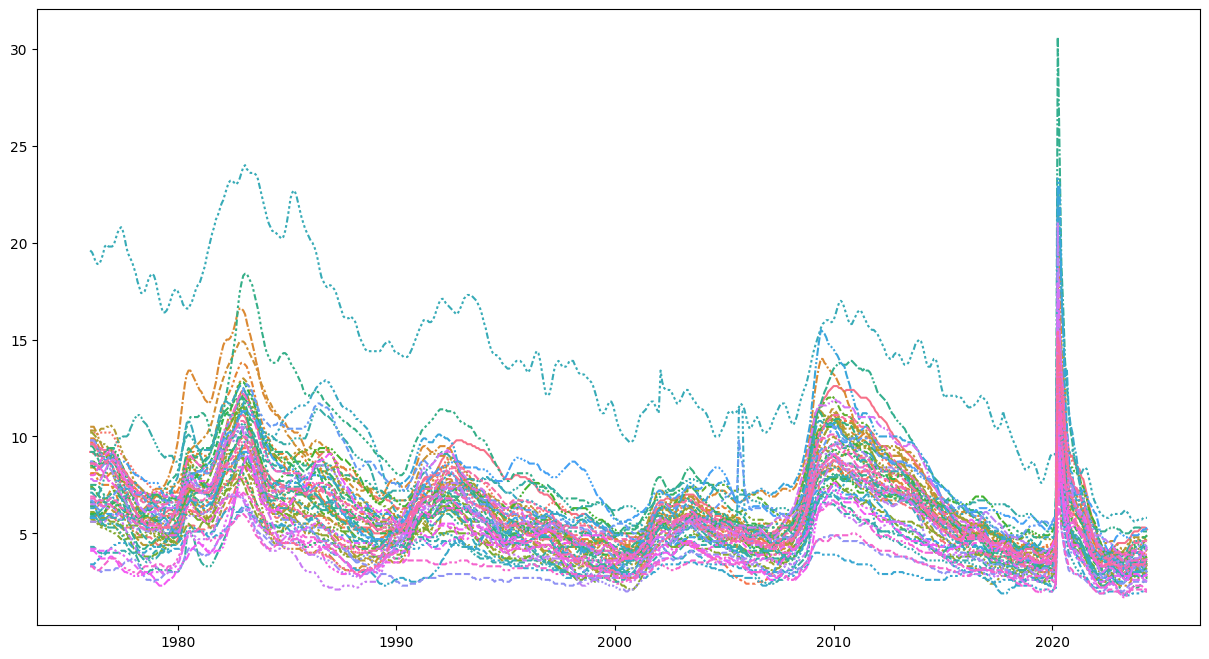

In [5]:
plt.figure(figsize=(15,8))
sns.lineplot(dfUnrate, legend=False)

Text(0, 0.5, 'Tasso di disoccupazione')

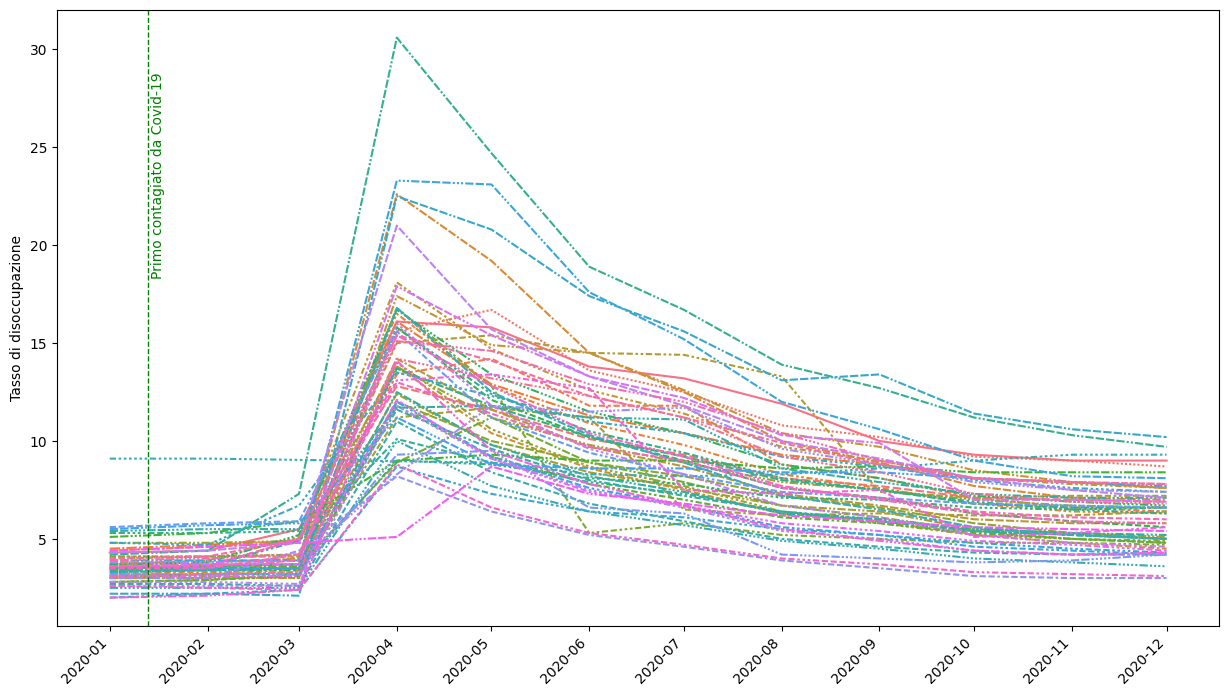

In [6]:
dfUnrate2020 = dfUnrate[(dfUnrate.index >= "2020-01-01") & (dfUnrate.index <= "2020-12-31")]
dfIndex2020 = df[(df.index >= "2020-01-01") & (df.index <= "2020-12-31")][['SP500', 'NASDAQCOM']]
plt.figure(figsize=(15,8))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(dfUnrate.index, rotation=45, ha='right')
sns.lineplot(dfUnrate2020, legend=False)
plt.axvline(x=pd.to_datetime("2020-01-13"), color='g', linestyle='--', linewidth=1)
plt.text(pd.to_datetime("2020-01-14"), plt.ylim()[1]*0.9, 'Primo contagiato da Covid-19', color='green', rotation=90, verticalalignment='top')
plt.ylabel("Tasso di disoccupazione")



<Axes: xlabel='date_updated', ylabel='tot_cases'>

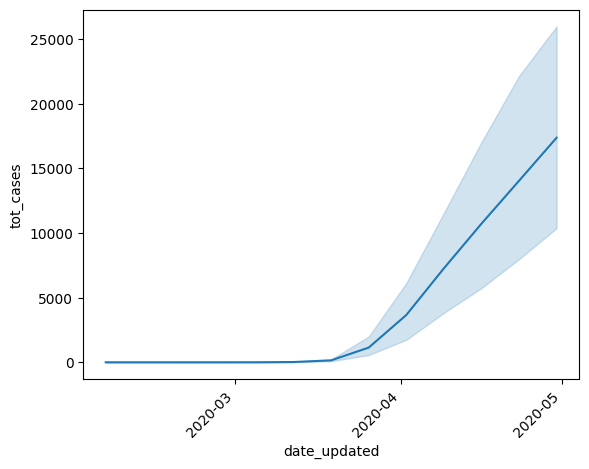

In [7]:
# Importing covid cases per state

covidCasesDf = pd.read_csv("data/covid_per_state.csv")
covidCasesDf['date_updated'] = pd.to_datetime(covidCasesDf['date_updated'])
covidCasesDf['start_date'] = pd.to_datetime(covidCasesDf['start_date'])
covidCasesDf['end_date'] = pd.to_datetime(covidCasesDf['end_date'])

covid2020Filter = (covidCasesDf['date_updated'] >= "2020-01-31") & (covidCasesDf['date_updated'] <= "2020-4-30")
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(dfUnrate.index, rotation=45, ha='right')
sns.lineplot(covidCasesDf[covid2020Filter], x='date_updated', y='tot_cases')


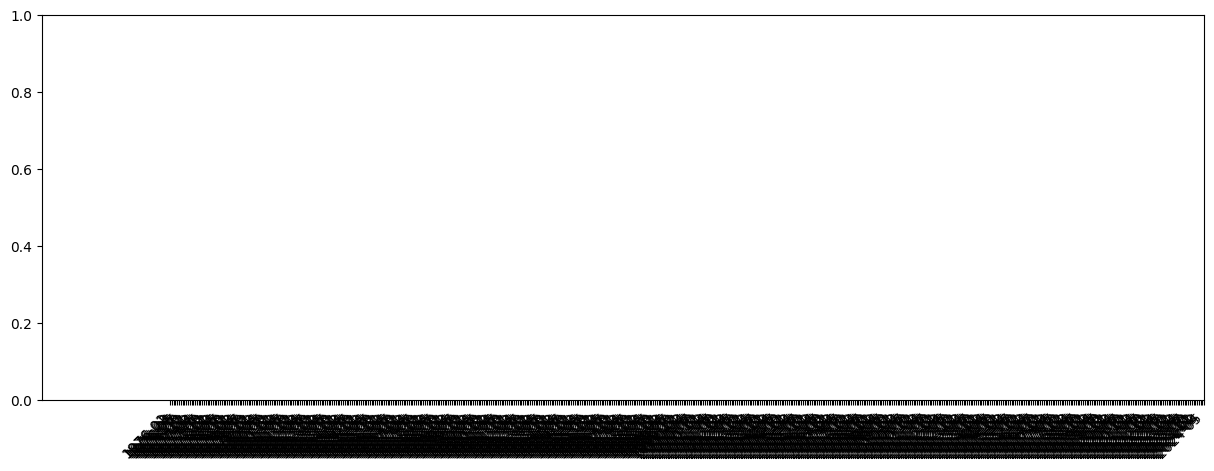

In [8]:
plt.figure(figsize=(15,5))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(dfUnrate.index, rotation=45, ha='right')
inflationIndex2020 = (inflation.index >= "2020-02-01") & (inflation.index <= "2020-5-31")


<Axes: xlabel='Date', ylabel='Tasso di Inflazione [%]'>

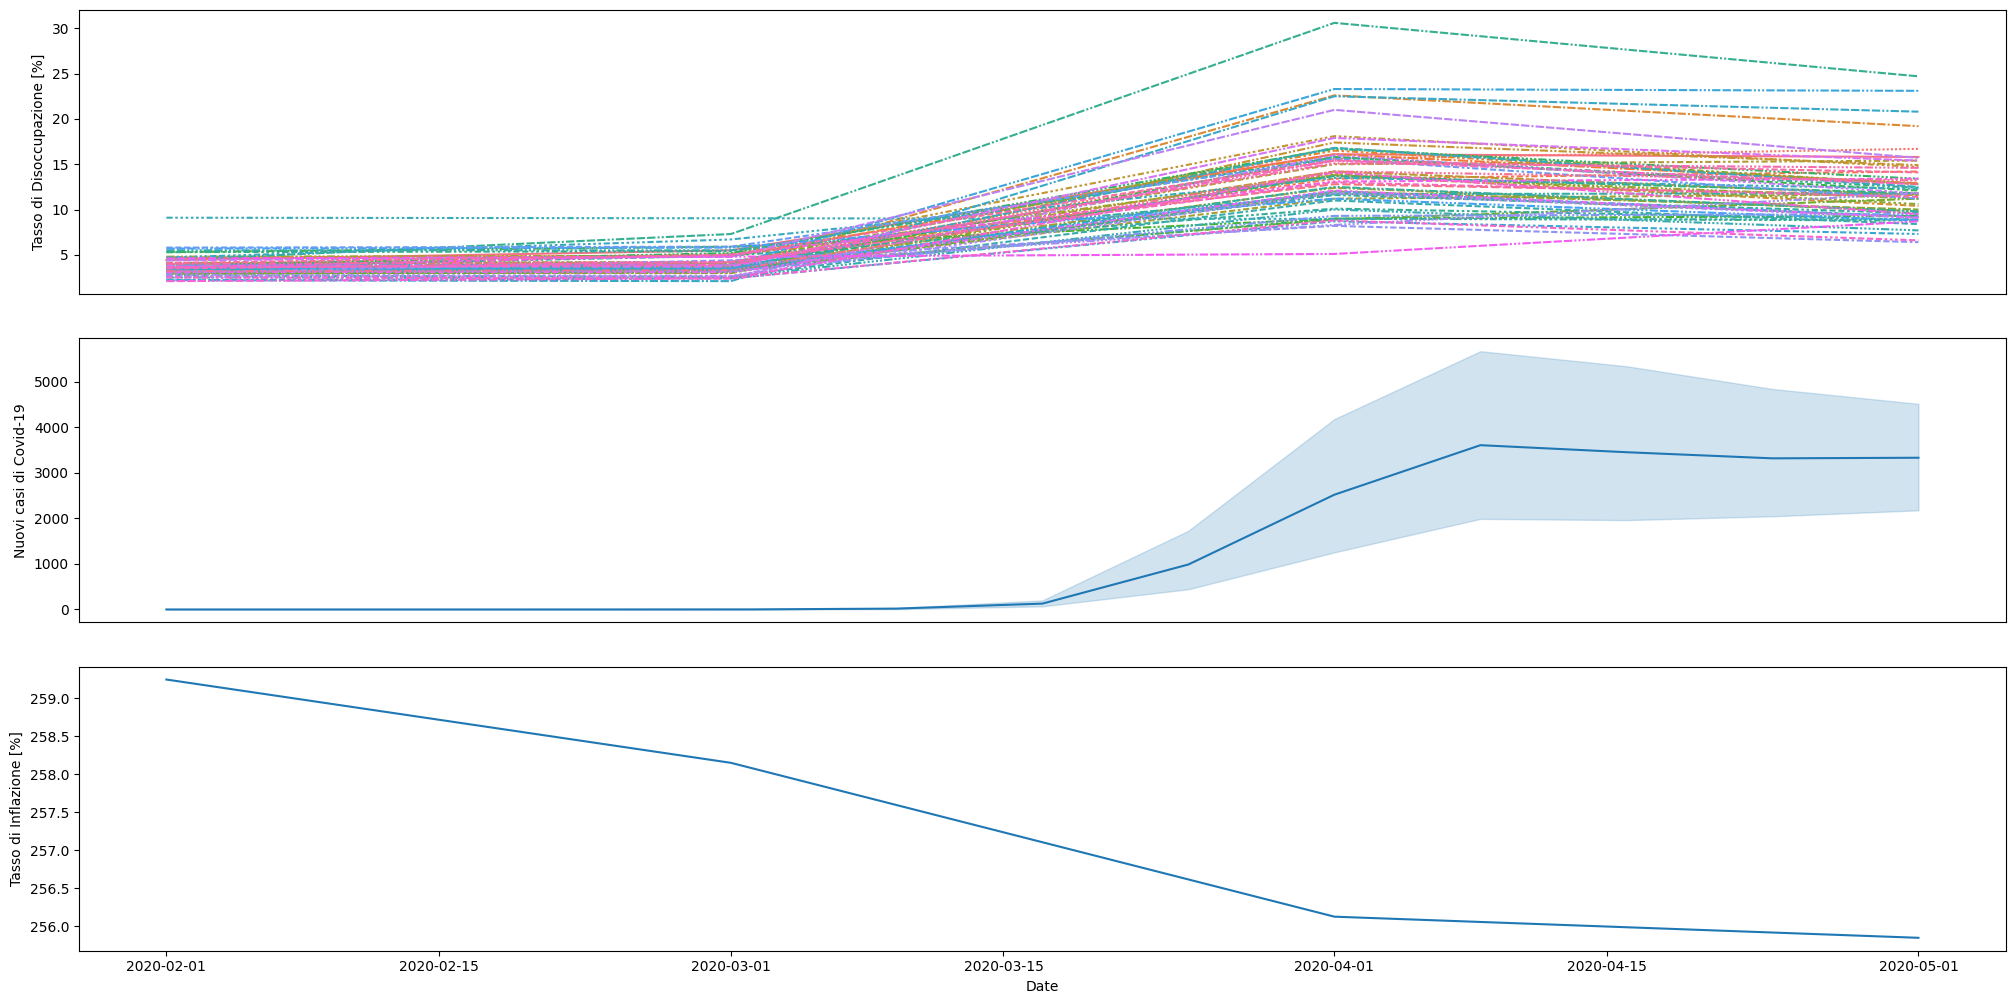

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,10))
dfUnrate2020 = dfUnrate[(dfUnrate.index >= "2020-02-01") & (dfUnrate.index <= "2020-5-31")]

plt.tight_layout()
# Rimuovi le etichette x dai grafici superiori
ax[0].set_xlabel('')
ax[0].set_ylabel('Tasso di Disoccupazione [%]')
ax[1].set_ylabel('Nuovi casi di Covid-19')
ax[1].set_xlabel('')
ax[2].set_xlabel("Date")
ax[2].set_ylabel('Tasso di Inflazione [%]')
ax[0].xaxis.set_visible(False)  # Nascondi l'asse x
ax[1].xaxis.set_visible(False)  # Nascondi l'asse x

sns.lineplot(dfUnrate2020, legend=False, ax=ax[0])
sns.lineplot(covidCasesDf[covid2020Filter], x='date_updated', y='new_cases', ax=ax[1])
sns.lineplot(inflation[inflationIndex2020], ax=ax[2])

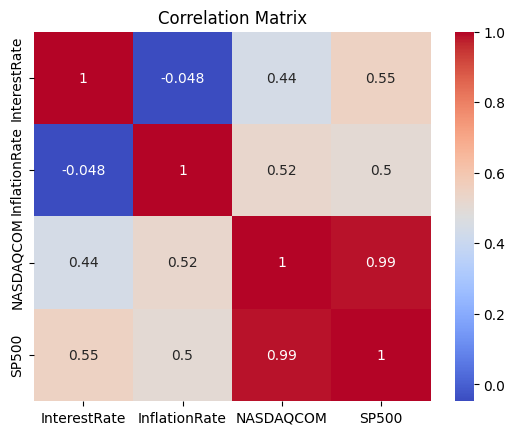

In [10]:
# Retrieving Data
# Interest rate
interestRate = fred.get_series("FEDFUNDS")
# Inflation Rate
inflationRate = fred.get_series("CPIAUCSL")
# NASDAQ
nasdaqcom = fred.get_series("NASDAQCOM")
# SP500
sp500 = fred.get_series("SP500")
# Merging Series into a DF
data = pd.DataFrame({
    "InterestRate": interestRate,
    'InflationRate': inflationRate.pct_change() * 100,
    "NASDAQCOM": nasdaqcom,
    "SP500": sp500
}).dropna()

# Plotting the correlation matrix into an heatmap
plt.title('Correlation Matrix')
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Prendiamo i dati di input
X = data[['InflationRate', 'InterestRate', 'SP500']]
y = data['NASDAQCOM']


model = LinearRegression()

model.fit(X, y)


print("Coefficiente Inflazione:", model.coef_[0])
print("Coefficiente Tasso di Interesse:", model.coef_[1])
print("Coefficiente SP500:", model.coef_[2])
print("Intercetta:", model.intercept_)

# Calcoliamo R^2
y_pred = model.predict(X)
print("R^2:", r2_score(y, y_pred))


Coefficiente Inflazione: -374.4707739823386
Coefficiente Tasso di Interesse: -325.6850827887338
Coefficiente SP500: 4.211866820725106
Intercetta: -3563.302766397823
R^2: 0.9882799385143398


<Axes: xlabel='SP500', ylabel='NASDAQCOM'>

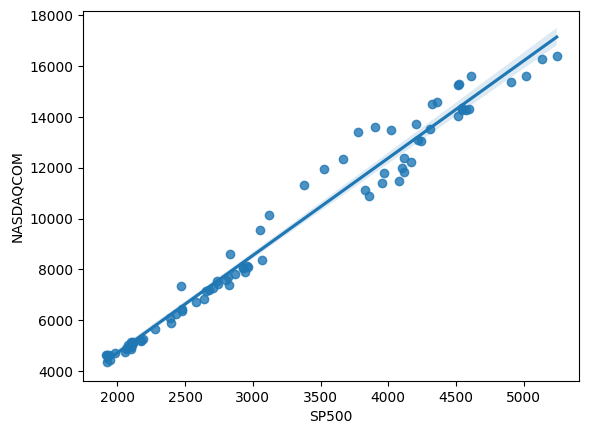

In [13]:
sns.regplot(data=data, x=data['SP500'], y=data['NASDAQCOM'])